# 8 Queens

### Introduction

<figure>
<img src="resources/eight_queens_moves.png", width=300 align="right">
    <figcaption></figcaption>
</figure>

The [Eight Queens puzzle](https://en.wikipedia.org/wiki/Eight_queens_puzzle) is a famous puzzle that has been studied extensively in- and outside of computer science. It was first published in the chess magazine _Schach_ in 1848. 

The problem can be formulated as follows: 

_"Place 8 queens on a regular (8x8) chess board such that no queen attacks any other queen."_

A queen in the game of chess can move horizontally, vertically, and diagonally. The puzzle can be solved by hand (and even [Carl Friedrich Gauss](https://en.wikipedia.org/wiki/Carl_Friedrich_Gauss) studied it back in 1850).

The EightQueensState class below, as well as the methods defined, should prove a helpful start for a Genetic Algorithms approach. However, you are welcome to change as little or as much of the code as is useful.

### Genetic Algorithm: Baseline solution
Only usable for 8 Queens Puzzle

In [1]:
import numpy as np

class EightQueensState:
    """This class represents a board in the eight queens puzzle"""
    def __init__(self, state=None, n=8):
        """
        :param state: pass in a numpy array of integers to set the state, otherwise will be generated randomly
        :param n: only used if state is not provided, determines size of board (default: 8)
        """
        if state is None:
            self.n = n
            state = np.random.randint(0, n, n)
        else:
            self.n = len(state)
        self.state = state

    @staticmethod
    def copy_replace(state, i, x):
        """This creates a copy of the state (important as numpy arrays are mutable) with column i set to x"""
        new_state = state.copy()
        new_state[i] = x
        return new_state

    @staticmethod
    def range_missing(start, stop, missing):
        """
        This creates a list of numbers with a single value missing
        e.g. range_missing(0, 8, 2) -> [0, 1, 3, 4, 5, 6, 7]
        """
        return list(range(start, missing)) + list(range(missing + 1, stop))

    def cost(self):
        """Calculates the number of pairs attacking"""
        count = 0
        for i in range(len(self.state) - 1):
            # for each queen, look in columns to the right
            # add one to the count if there is another queen in the same row
            count += (self.state[i] == np.array(self.state[i + 1:])).sum()

            # add one to the count for each queen on the upper or lower diagonal
            upper_diagonal = self.state[i] + np.arange(1, self.n - i)
            lower_diagonal = self.state[i] - np.arange(1, self.n - i)
            count += (np.array(self.state[i + 1:]) == upper_diagonal).sum()
            count += (np.array(self.state[i + 1:]) == lower_diagonal).sum()
        return count
    
    def neighbourhood(self):
        """This generates every state possible by changing a single queen position
            if n = 8 then 7 * 8 = 56 new states
        """
        neighbourhood = []
        for column in range(self.n):
            for new_position in self.range_missing(0, self.n, self.state[column]):
                new_state = self.copy_replace(self.state, column, new_position)
                neighbourhood.append(EightQueensState(new_state))

        return neighbourhood

    def random_neighbour(self):
        """
        Generates a single random neighbour state, useful for some algorithms
        This per each individual (state) applies mutation (on one of its genes) only if 
        the probability of mutation is met
        """
        # the column is choosen randomly picking a number between 0 and 7
        column = np.random.choice(range(self.n)) 
        # choose a value in the position (row) by randomly picking its column between 0 and 7, but omitting the previous picked column
        # the new_position can be any row (in the calculated column) but the one where there is already a queen
        new_position = np.random.choice(self.range_missing(0, self.n, self.state[column]))
        # randomly choose value between 0 and 1
        random_number = np.random.random(1)[0]
        # define the probability mutation threshold
        prob_mutation = 0.01 # generally it is between 0.001 and 0.01
        # using mutation operator to apply mutation only if the random value is below the threshold
        if random_number < prob_mutation:
            # new column and position are used to get the new_state: self.state[column] = new_position. This means
            # substitute in the state one value with another one which is different from the current one.
            # self.state[column] = 6 hence substitute 6 with any other number from 0 to 7 but 6
            # at the calculated column, move the queen from its position to a new position (randomly choosen) in the same column
            new_state = self.copy_replace(self.state, column, new_position) 
        else:
            new_state = self.state
            
        return EightQueensState(new_state)

    def is_goal(self):
        # the algorithm has converged when there are no queens attaking each other
        return self.cost() == 0

    def __str__(self):
        if self.is_goal():
            return f"Goal state! {self.state}"
        else:
            return f"{self.state} cost {self.cost()}"

In [2]:
import random

def fitness_calc(state):
    """Calculates the Fitness function for each solution"""
        
    # the maximum number of queen-on-queen attacks accouting for the simmetry will be: n_queens * (n_queens-1) / 2
    max_attack_pairs = 8 * (8-1) / 2
    fitness = max_attack_pairs - state.cost()
    return fitness


def probability_for_selection(fitness_state, fitness_total):
    """
    This uses the fitness value of an individual (state) to how his fitness relates (in percentage) 
    with the total fitness of the population. It is also called normalised fitness
    This would be used as the probability for selecting an individual (state) for the mating pool 
    The sum of the probablities of the entire population is equal to 1
    """
    prob_selec = fitness_state / fitness_total
    return prob_selec


def roulette_wheel_selection(states, prob_selec):
    """
    To order the states based on their probability of selection
    To calculate the cumulative probability starting from the top state
    To randomly select states favouring the one with higher probability
    """
    # ordering the states based on their normalised fitness values
    list_idx = list(range(len(prob_selec)))
    order_prob, order_idx = zip(*sorted(zip(prob_selec, list_idx), reverse=True))
    order_prob = list(order_prob)
    order_idx = list(order_idx)
    
    order_states = []
    for idx in order_idx:
        order_states.append(states[idx])

    order_states = list(order_states)
    
    # cumulative probability
    cum_prob = []
    cum_prob_val = 0
    for idx in range(len(states)):
        cum_prob_val += order_prob[idx]
        cum_prob.append(cum_prob_val)
    
    
    # Randombly select states based on their cumulative probability (cum_prob) 
    # If the random number (choosen between 0 and 1) is <= cum_prob[0] then choose order_states[0]
    # If the random number (choosen between 0 and 1) is > cum_prob[0] and < cum_prob[1] then choose order_states[1]
    # ...
    select_states = []
    population_size = len(cum_prob)
    for count in range(population_size):
        random_number = np.random.random(1)[0]
        position = 0
        for score in cum_prob:
            if random_number <= score:
                select_states.append(order_states[position])
                break
            position += 1
    
    return select_states


def crossover(states):
    """
    This swaps the values in the string of two individuals (parents) from the cutoff to the end
    This assumes a probability of crossover equal to 1 (each parents go under crossover)
    """
    
    # define the probability mutation threshold
    prob_crossover = 1 # generally it is between 0.45 and 1 (1 means always doing crossover)
    
    # randomly selecting the crossover site
    cutoff = random.randrange(1, 8) # n=8 then random numbers from 1 to 7 included
    num_states = len(states)
    cross_states = []
    for idx in range(num_states):
        if (idx % 2) == 0:
            # randomly choose value between 0 and 1
            random_number = np.random.random(1)[0]
            # assign parents
            state_x = states[idx]
            state_y = states[idx+1]
            # only do the crossover between the parents if the probability is met
            if random_number < prob_crossover:
                for i in range(cutoff, 8):

                    state_x_state = EightQueensState.copy_replace( state_x.state, i, state_y.state[i] )
                    state_y_state = EightQueensState.copy_replace( state_y.state, i, state_x.state[i] )
                    state_x = EightQueensState(state_x_state)
                    state_y = EightQueensState(state_y_state)
                
            cross_states.append(state_x)
            cross_states.append(state_y)
    
    return cross_states


def mutate(state):
    """This randomly mutate one gene in each individual if and only if the random value is below probability threshold"""
    
    return state.random_neighbour()

from time import time



def iterate_generations(states):
    """
    This iterates the through the steps of the Genetic Algorithm:
    - Determine Fitness of the individuals
    - Select the most fitted individuals for reproduction
    - Apply crossover to each couple pf parents to create new offsprings
    - Apply mutation to each offspring to get the new generation
    
    """

    # Calculate the fitness value per each individual (state) of the population
    fitness_states = [fitness_calc(state) for state in states] # list
    # Calculate the total fitness value of the entire population
    fitness_total = sum(fitness_states)

    # Calculate probability selection value per each individual (state) of the population
    probability_states = [probability_for_selection(fitness_state, fitness_total) for fitness_state in fitness_states] # list 
    
    # Apply Reproduction
    reproduction_states = roulette_wheel_selection(states, probability_states)

    # Apply Crossing
    cross_states = crossover(reproduction_states)
  
    
    # Apply Mutation
    mut_states = [mutate(state) for state in cross_states]
    
    return mut_states
    


In [3]:
# Define the initial number of states (population size): from 2*n to 4*n (n = number of queens)
num_states = 2 * 8 

states = []
for idx in range(num_states):
    state = EightQueensState()
    state.__init__(None)
    states.append(state)


print("starting generation:")
print()
[print(str(state)) for state in states]
print()


starting generation:

[2 3 0 4 1 6 2 7] cost 4
[7 4 1 5 6 7 4 2] cost 6
[3 6 1 6 1 4 0 2] cost 8
[1 4 7 6 4 4 3 4] cost 14
[1 4 3 1 0 6 3 0] cost 8
[7 1 3 0 4 7 1 2] cost 5
[3 1 6 4 4 3 5 5] cost 8
[0 5 2 2 0 1 6 5] cost 10
[1 0 0 4 3 0 4 5] cost 11
[5 1 1 5 3 2 0 6] cost 6
[5 7 3 1 5 0 2 6] cost 6
[2 3 5 0 6 7 3 5] cost 10
[7 1 6 3 7 5 4 5] cost 7
[6 6 6 1 6 7 3 5] cost 9
[5 7 7 6 5 5 3 6] cost 12
[0 1 5 5 0 5 0 1] cost 12



Run Genetic Algorithm optimization till convergence.

In [4]:
%%time
max_iter = 100000  
iteration = 0
costs =[]
best_state= EightQueensState()
while (iteration < max_iter) and (best_state.cost() > 0 ):
    # run iterate_generation till convergence
    states = iterate_generations(states)
    iteration += 1
    # at each iteration (generation) select the state (individual) that has the lowest cost
    best_state_idx = np.argmin(np.array([state.cost() for state in states]))
    best_state = states[best_state_idx]
    
    costs.append(best_state.cost())


Wall time: 2min 29s


Print GA outputs

Iteration N: 35681
Final cost: 0
Goal state! [1 5 0 6 3 7 2 4]


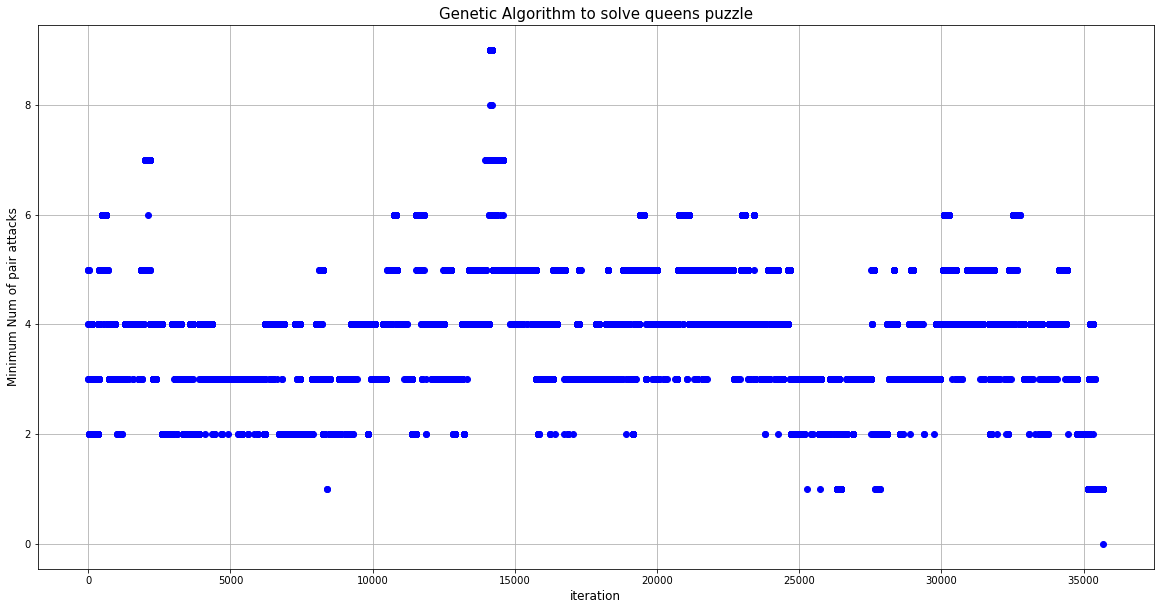

In [5]:
print('Iteration N:', iteration)
print('Final cost:', costs[-1])
print(best_state)

from matplotlib import pyplot as plt

plt.figure(figsize=[20, 10])
plt.plot(costs, 'o', color='blue')
plt.rcParams['font.size'] = '14' # Set general font size
plt.xlabel('iteration', fontsize=12)
plt.ylabel('Minimum Num of pair attacks', fontsize=12)
plt.title('Genetic Algorithm to solve queens puzzle', fontsize=15)
plt.grid()
plt.show()

### Genetic Algorithm: Advanced solution

This version can solve n-Queens with n ≠ 8. <br>
Moreover, considering that the effectiveness of the GAs it is highly dependent on the selection of its control parameters:
- population size
- probability of crossover
- probability of mutation

In this solution, the code has been adapted to allow the control of those parameters and specifically the `iterate_generations` function is the one containing them.

Here following the `EightQueensState` class that has been modified in order to speed up the execution of the code. In particular, the functions `random_neighbour` and `cost` have been modified to avoid unnecessary calculations. 

In [6]:
import numpy as np

class EightQueensState:
    """This class represents a board in the eight queens puzzle"""
    def __init__(self, state=None, n=8, calc_cost=True):
        """
        :param state: pass in a numpy array of integers to set the state, otherwise will be generated randomly
        :param n: only used if state is not provided, determines size of board (default: 8)
        """
        self.prob_mutation = 0
        if state is None:
            self.n = n
            state = np.random.randint(0, n, n)
        else:
            self.n = len(state)
        self.state = state
        # only run the cost function if necessary
        if calc_cost:
            self.state_cost = self.cost()

    def set_data(self, prob_mutation):
        """Collect the data in input"""
        self.prob_mutation = prob_mutation
        
    @staticmethod
    def copy_replace(state, i, x):
        """This creates a copy of the state (important as numpy arrays are mutable) with column i set to x"""
        new_state = state.copy()
        new_state[i] = x
        return new_state

    @staticmethod
    def range_missing(start, stop, missing):
        """
        This creates a list of numbers with a single value missing
        e.g. range_missing(0, 8, 2) -> [0, 1, 3, 4, 5, 6, 7]
        """
        return list(range(start, missing)) + list(range(missing + 1, stop))

    def cost(self):
        """Calculates the number of pairs attacking"""
        count = 0
        
        for i in range(len(self.state) - 1):
            # for each queen, look in columns to the right
            # add one to the count if there is another queen in the same row
            state_i = self.state[i]
            count += (state_i == np.array(self.state[i + 1:])).sum()
            a_range=np.arange(1, self.n - i)

            # add one to the count for each queen on the upper or lower diagonal
            upper_diagonal = state_i + a_range
            lower_diagonal = state_i - a_range
            count += (np.array(self.state[i + 1:]) == upper_diagonal).sum()
            count += (np.array(self.state[i + 1:]) == lower_diagonal).sum()
        return count
    
    def neighbourhood(self):
        """This generates every state possible by changing a single queen position
            if n = 8 then 7 * 8 = 56 new states
        """
        neighbourhood = []
        for column in range(self.n):
            for new_position in self.range_missing(0, self.n, self.state[column]):
                new_state = self.copy_replace(self.state, column, new_position)
                neighbourhood.append(EightQueensState(new_state))

        return neighbourhood

    def random_neighbour(self, prob_mutation=0.01):
        """
        Generates a single random neighbour state, useful for some algorithms
        This per each individual (state) applies mutation (on one of its genes) only if 
        the probability of mutation is met
        """
       
        # randomly choose value between 0 and 1
        random_number = np.random.random(1)[0]
        # define the probability mutation threshold
        # using mutation operator to apply mutation only if the random value is below the threshold
        if random_number < prob_mutation:
            # new column and position are used to get the new_state: self.state[column] = new_position. This means
            # substitute in the state one value with another one which is different from the current one.
            # self.state[column] = 6 hence substitute 6 with any other number from 0 to 7 but 6
            # at the calculated column, move the queen from its position to a new position (randomly choosen) in the same column
             # the column is choosen randomly picking a number between 0 and 7
            column = np.random.choice(range(self.n)) 
            # choose a value in the position (row) by randomly picking its column between 0 and 7, but omitting the previous picked column
            # the new_position can be any row (in the calculated column) but the one where there is already a queen
            new_position = np.random.choice(self.range_missing(0, self.n, self.state[column]))
            
            new_state = self.copy_replace(self.state, column, new_position) 
        else:
            new_state = self.state
        return EightQueensState(new_state)
            


    def is_goal(self):
        # the algorithm has converged when there are no queens attaking each other
        return self.cost() == 0

    def __str__(self):
        if self.is_goal():
            return f"Goal state! {self.state}"
        else:
            return f"{self.state} cost {self.cost()}"

In [7]:
def iterate_generations(states, n_queens):
    """
    1. This is to choose the most optimal parameters of the genetic algorithm based on studies on GA 
        (Imp: it is not scanning to find the best parameters for this specific case):
        prob_crossover: probability to crossover
        prob_mutation: probability to mutate
    2. This iterates the through the steps of the Genetic Algorithm:
        - Determine Fitness of the individuals
        - Select the most fitted individuals for reproduction
        - Apply crossover to each couple pf parents to create new offsprings
        - Apply mutation to each offspring to get the new generation
    """
    
    # define the probability mutation threshold
    prob_crossover = 0.9 # generally it is between 0.45 and 1 (1 means always doing crossover)
    prob_mutation = 0.01 # generally it is between 0.001 and 0.05
    num_states = len(states)
    
    # Calculate the fitness value per each individual (state) of the population
    fitness_states = [fitness_calc(state, n_queens) for state in states] # list
    # Calculate the total fitness value of the entire population
    fitness_total = sum(fitness_states)

    # Calculate probability selection value per each individual (state) of the population
    probability_states = [probability_for_selection(fitness_state, fitness_total) for fitness_state in fitness_states] # list 
    
    # Apply Reproduction
    reproduction_states = roulette_wheel_selection(states, probability_states)

    # Apply Crossing
    cross_states = crossover(reproduction_states, n_queens, prob_crossover)
  
    # Apply Mutation
    mut_states = [mutate(state) for state in cross_states]
    
    return mut_states
    


In [8]:
import random

def fitness_calc(state, max_attack_pairs):
    """Calculates the Fitness function for each solution"""
    # the maximum number of queen-on-queen attacks accouting for the simmetry will be: n_queens * (n_queens-1) / 2
    fitness = max_attack_pairs - state.state_cost
    return fitness


def probability_for_selection(fitness_state, fitness_total):
    """
    This uses the fitness value of an individual (state) to how his fitness relates (in percentage) 
    with the total fitness of the population. It is also called normalised fitness
    This would be used as the probability for selecting an individual (state) for the mating pool 
    The sum of the probablities of the entire population is equal to 1
    """
    prob_selec = fitness_state / fitness_total
    return prob_selec


def roulette_wheel_selection(states, prob_selec):
    """
    To order the states based on their probability of selection
    To calculate the cumulative probability starting from the top state
    To randomly select states favouring the one with higher probability
    """
    # ordering the states based on their normalised fitness values
    list_idx = list(range(len(prob_selec)))
    order_prob, order_idx = zip(*sorted(zip(prob_selec, list_idx), reverse=True))
    order_prob = list(order_prob)
    order_idx = list(order_idx)
    
    order_states = []
    for idx in order_idx:
        order_states.append(states[idx])

    order_states = list(order_states)
    
    # cumulative probability
    cum_prob = []
    cum_prob_val = 0
    for idx in range(len(states)):
        cum_prob_val += order_prob[idx]
        cum_prob.append(cum_prob_val)
    
    
    # Randombly select states based on their cumulative probability (cum_prob) 
    # If the random number (choosen between 0 and 1) is <= cum_prob[0] then choose order_states[0]
    # If the random number (choosen between 0 and 1) is > cum_prob[0] and < cum_prob[1] then choose order_states[1]
    # ...
    select_states = []
    population_size = len(cum_prob)
    for count in range(population_size):
        random_number = np.random.random(1)[0]
        position = 0
        for score in cum_prob:
            if random_number <= score:
                select_states.append(order_states[position])
                break
            position += 1
    
    return select_states


def crossover(states, n_queens, prob_crossover):
    """
    This swaps the values in the string of two individuals (parents) from the cutoff to the end
    This assumes a probability of crossover equal to 1 (each parents go under crossover)
    """
    
    # randomly selecting the crossover site
    cutoff = random.randrange(1, n_queens) # n=8 then random numbers from 1 to 7 included
    num_states = len(states)
    cross_states = []
    for idx in range(num_states):
        if (idx % 2) == 0:
            # randomly choose value between 0 and 1
            random_number = np.random.random(1)[0]
            # assign parents
            state_x = states[idx]
            state_y = states[idx+1]
            # only do the crossover between the parents if the probability is met
            if random_number < prob_crossover:
                for i in range(cutoff, n_queens):

                    state_x_state = EightQueensState.copy_replace( state_x.state, i, state_y.state[i] )
                    state_y_state = EightQueensState.copy_replace( state_y.state, i, state_x.state[i] )
                    state_x = EightQueensState(state_x_state, calc_cost=False)
                    state_y = EightQueensState(state_y_state, calc_cost=False)
                
            cross_states.append(state_x)
            cross_states.append(state_y)
                
    return cross_states


def mutate(state, prob_mutation=0.01):
    """This randomly mutate one gene in each individual if and only if the random value is below probability threshold"""
    
    return EightQueensState.random_neighbour(state, prob_mutation=prob_mutation)





Define:
- probability of crossover **`prob_crossover`**
- probability of mutation **`prob_mutation`**

As per Ahmad Hassanat (2019), here is a list of GA optimal parameters:
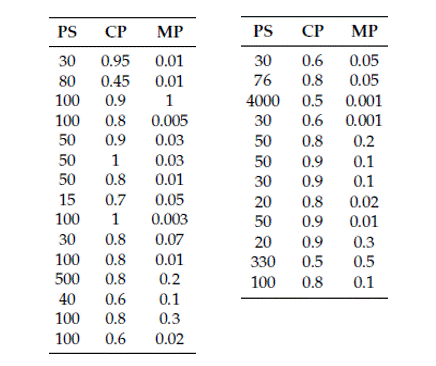

Those parameter values are here only as a guidance on how to calibrate the GA parameters for better convergence. The best way forward could be to run a brute force analysis to sweep their values and so identify what could be the best combination for this specific problem (the queens puzzle).<br>
As stated by Hassanat (2019), "The crossover and mutation rates was proofed as key elements to success in the search in the GAs". Hassanat goes on saying that "Keeping a balance between crossover and mutation rates is an issue of controlling parameters in GA. As a matter of fact, controlling values is one of the most important areas of research in GA".
Going into the detail, Hassanat suggests that studies have shown that crossover is more effective than mutation in large population size, conversely mutation is more effective for small population size.


In [9]:
def iterate_generations(states, n_queens, max_attack_pairs):
    """
    1. This is to choose the most optimal parameters of the genetic algorithm based on studies on GA 
        (Imp: it is not scanning to find the best parameters for this specific case):
        prob_crossover: probability to crossover
        prob_mutation: probability to mutate
    2. This iterates the through the steps of the Genetic Algorithm:
        - Determine Fitness of the individuals
        - Select the most fitted individuals for reproduction
        - Apply crossover to each couple pf parents to create new offsprings
        - Apply mutation to each offspring to get the new generation
    """
    
    # define the probability mutation threshold
    prob_crossover = 0.8 # generally it is between 0.45 and 1 (1 means always doing crossover)
    prob_mutation = 0.02 # generally it is between 0.001 and 0.05
    num_states = len(states)
    
    
    # Calculate the fitness value per each individual (state) of the population
    fitness_states = [fitness_calc(state, max_attack_pairs) for state in states] # list
    # Calculate the total fitness value of the entire population
    fitness_total = sum(fitness_states)

    # Calculate probability selection value per each individual (state) of the population
    probability_states = [probability_for_selection(fitness_state, fitness_total) for fitness_state in fitness_states] # list 
    
    # Apply Reproduction
    reproduction_states = roulette_wheel_selection(states, probability_states)

    # Apply Crossing
    cross_states = crossover(reproduction_states, n_queens, prob_crossover)
  
    # Apply Mutation
    mut_states = [mutate(state, prob_mutation=prob_mutation) for state in cross_states]
    
    return mut_states
    


Define:
- the number of queens **`n_queens`**. 

Whereas, about the initial number of states, as stated by Rao (2009), "*If the number of design variables is n, usually the size of the population is taken as 2n to 4n.*"

In [10]:
# Define the number of queens
n_queens = 8

# Define the initial number of states (population size): from 2*n to 4*n (n = number of queens)
num_states = 2 * n_queens


# randomly creating an initial population (states)
states = []
for idx in range(num_states):
    state = EightQueensState()
    state.__init__(None, n_queens)
    states.append(state)



print("starting generation:")
print()
[print(str(state)) for state in states]
print()


starting generation:

[7 7 5 0 2 0 4 6] cost 4
[0 6 2 7 3 7 1 2] cost 7
[1 7 1 5 1 5 6 6] cost 8
[1 3 6 1 4 2 6 5] cost 7
[3 0 2 1 5 4 6 6] cost 7
[4 6 1 3 4 6 7 0] cost 5
[7 5 6 3 6 5 1 6] cost 9
[4 7 0 5 7 1 6 2] cost 2
[5 6 7 5 6 3 0 2] cost 8
[5 7 4 1 4 7 4 0] cost 7
[5 2 1 4 2 0 7 4] cost 7
[0 7 7 6 3 7 0 1] cost 7
[6 7 6 0 7 3 4 6] cost 9
[1 7 2 0 7 3 4 6] cost 3
[5 6 5 6 6 6 2 7] cost 10
[6 5 0 5 0 6 7 1] cost 6



Run Genetic Algorithm optimization till convergence.

In [11]:
%%time
max_iter = 100000  
iteration = 0
costs =[]
best_state= EightQueensState()
max_attack_pairs = n_queens * (n_queens-1) / 2
while (iteration < max_iter) and (best_state.state_cost > 0 ):
    # run iterate_generation till convergence
    states = iterate_generations(states, n_queens, max_attack_pairs)
    iteration += 1
    # at each iteration (generation) select the state (individual) that has the lowest cost
    best_state_idx = np.argmin(np.array([state.state_cost for state in states]))
    best_state = states[best_state_idx]
    costs.append(best_state.state_cost)



Wall time: 38.7 s


Print GA outputs

Iteration N: 21433
Final cost: 0
Goal state! [5 2 6 3 0 7 1 4]


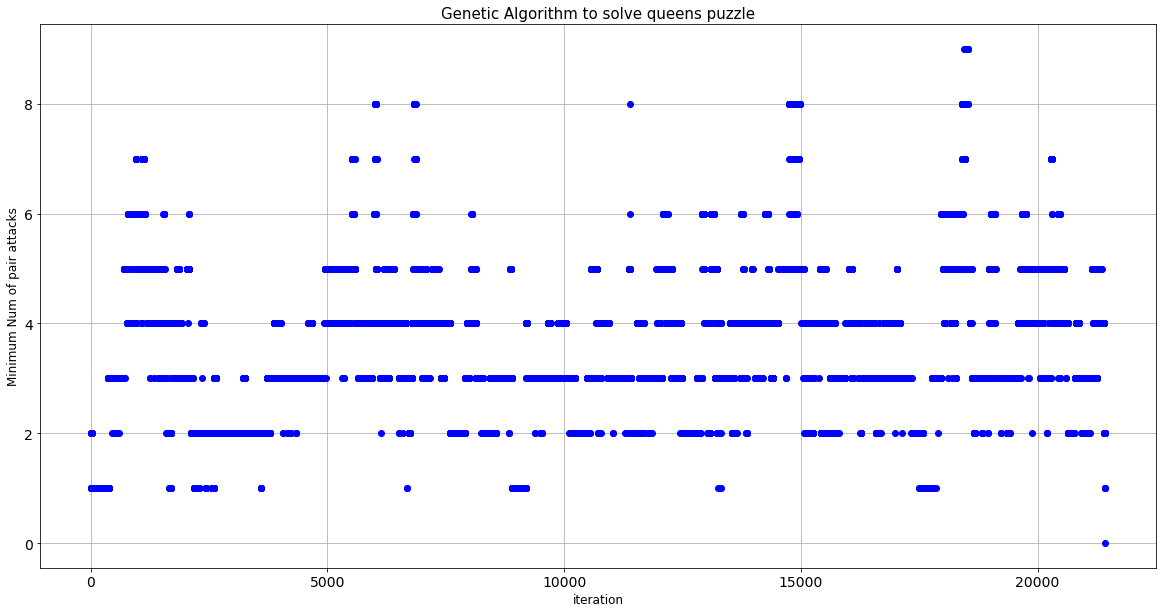

In [12]:
print('Iteration N:', iteration)
print('Final cost:', costs[-1])
print(best_state)

from matplotlib import pyplot as plt

plt.figure(figsize=[20, 10])
plt.plot(costs, 'o', color='blue')
plt.rcParams['font.size'] = '14' # Set general font size
plt.xlabel('iteration', fontsize=12)
plt.ylabel('Minimum Num of pair attacks', fontsize=12)
plt.title('Genetic Algorithm to solve queens puzzle', fontsize=15)
plt.grid()
plt.show()